# Bài thực hành lab03 - Khai thác dữ liệu - Naive Bayes
Họ và tên: Huỳnh Quang Trung\
MSSV: 20280108\
Lớp: 20TH_KDL\
Bài làm được thực hiện trên Google Colab

------

1. Analyze and Preprocess data - Check if the dataset has missing values or has any other problem.
2. Feature Engineering
3. Divide the dataset into 2 training and test sets
4. Use Pipeline
    4. a. Use scaler and dimensional reduction (if it is necessary).
    4. b. Use suitable Naive Bayes for this problem. 
5. Perform model on training set and test set using gridsearch CV
6. Measure performance of the model.
7. Which metric is your main metric for this problem and why? What are your scaler, dimensional reduction and naive bayes model as well as their params? (<= 200 words, also input your opinion or conclusion here)


How can I measure your point:
1. Your function is callable and runs correctly
2. The performance of your model (in full pipeline) is acceptable. The final error based on my train and test set is low enough.
3. The data preprocessing is correct or make sense
4. The Feature engineering is correct or make sense
5. Any other additional process will be considered a small plus point.

A Travel Company Is Offering Travel Insurance Packages To Their Customers. The new insurance plan also covers Covid-19. The Company Claims To Know Which Customers Are Interested To Buy It Based On The Company's Database History.

* Age - Age Of The Customer
* Employment Type - The Sector In Which Customer Is Employed
GraduateOrNot - Whether The Customer Is College Graduate Or Not
* AnnualIncome - The Yearly Income Of The Customer In Indian Rupees
* FamilyMembers - Number Of Members In Customer's Family
* ChronicDisease - Whether The Customer Suffers From Any Major Disease Or Conditions Like Diabetes/High BP or Asthama,etc.
* FrequentFlyer - Derived Data Based On Customer's History Of Booking Air Tickets On Atleast 4 Different Instances In The Last 2 Years (2017-2019).
* EverTravelledAbroad - Has The Customer Ever Travelled To A Foreign Country
* TravelInsurance - Did The Customer Buy Travel Insurance Package During Introductory Offering Held In The Year 2019.

## Load Dataset

In [236]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [237]:
import pandas as pd
PATH = "/content/drive/MyDrive/NMMH/Tuan3/TravelInsurancePrediction.csv"

df = pd.read_csv(PATH)
df.head()

,Unnamed: 0,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,0,31,Government Sector,Yes,400000,6,1,No,No,0
1,1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


## Data Analysis

In [238]:
df.shape

(1987, 10)

In [239]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1987.0,993.000000,573.741812,0.0,496.5,993.0,1489.5,1986.0
Age,1987.0,29.650226,2.913308,25.0,28.0,29.0,32.0,35.0
AnnualIncome,1987.0,932762.959235,376855.684748,300000.0,600000.0,900000.0,1250000.0,1800000.0
FamilyMembers,1987.0,4.752894,1.609650,2.0,4.0,5.0,6.0,9.0
ChronicDiseases,1987.0,0.277806,0.448030,0.0,0.0,0.0,1.0,1.0
TravelInsurance,1987.0,0.357323,0.479332,0.0,0.0,0.0,1.0,1.0


Ta thấy cột Unnamed: 0 là một cột thừa trong bộ dữ liệu, cột này có lẽ mang ý nghĩa là số thứ tự các bản ghi.

In [240]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           1987 non-null   int64 
 1   Age                  1987 non-null   int64 
 2   Employment Type      1987 non-null   object
 3   GraduateOrNot        1987 non-null   object
 4   AnnualIncome         1987 non-null   int64 
 5   FamilyMembers        1987 non-null   int64 
 6   ChronicDiseases      1987 non-null   int64 
 7   FrequentFlyer        1987 non-null   object
 8   EverTravelledAbroad  1987 non-null   object
 9   TravelInsurance      1987 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 155.4+ KB


In [241]:
df.isna().sum()

Unnamed: 0             0
Age                    0
Employment Type        0
GraduateOrNot          0
AnnualIncome           0
FamilyMembers          0
ChronicDiseases        0
FrequentFlyer          0
EverTravelledAbroad    0
TravelInsurance        0
dtype: int64

Bộ dữ liệu không có các giá trị Null hay NaN.

In [242]:
def unique_values(df, columns):
    unique_dict = {}
    for col in columns:
        unique_dict[col] = df[col].unique()
    return unique_dict

In [243]:
# Các cột categorical
categorical_col = ['Employment Type', 'GraduateOrNot', 'FrequentFlyer', 'EverTravelledAbroad', 'ChronicDiseases', 'TravelInsurance']
unique_values(df, categorical_col)

{'Employment Type': array(['Government Sector', 'Private Sector/Self Employed'], dtype=object),
 'GraduateOrNot': array(['Yes', 'No'], dtype=object),
 'FrequentFlyer': array(['No', 'Yes'], dtype=object),
 'EverTravelledAbroad': array(['No', 'Yes'], dtype=object),
 'ChronicDiseases': array([1, 0]),
 'TravelInsurance': array([0, 1])}

Ta thấy các cột categorical đều đã mang đúng các giá trị, không có các giá trị lạ xuất hiện.

### Age

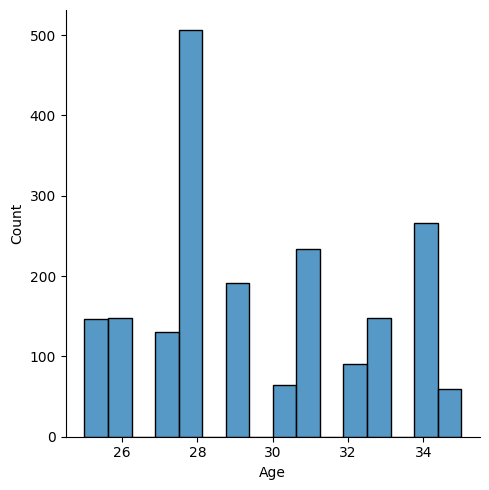

In [244]:
sns.displot(df['Age'])
plt.show()

Hầu hết khách hàng trong dataset có độ tuổi là 28.


<ipython-input-245-6803151ba590>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  (df.groupby('Age').sum()['TravelInsurance']/df.groupby('Age').count()['TravelInsurance']).plot(kind='bar')


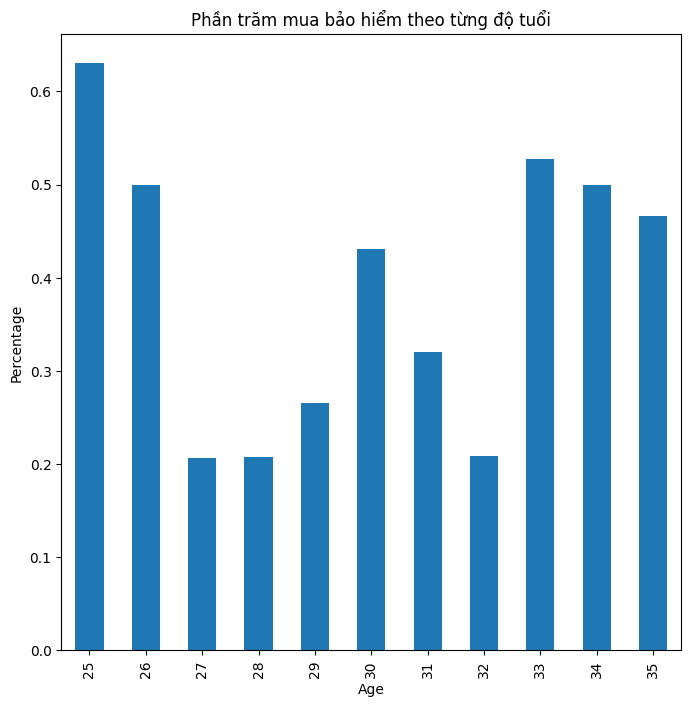

In [245]:
fig, ax = plt.subplots(figsize=(8,8))
(df.groupby('Age').sum()['TravelInsurance']/df.groupby('Age').count()['TravelInsurance']).plot(kind='bar')
plt.title('Phần trăm mua bảo hiểm theo từng độ tuổi')
plt.ylabel('Percentage')
plt.show()

Ta thấy độ tuổi 25 là độ tuổi có nhiều khách hàng mua bảo hiểm nhất, tiếp đó là độ tuổi từ 33-35 với mức mua trung bình và thấp nhất là độ tuổi từ 27-32

### Employment Type

<ipython-input-246-307eb9dfd0fa>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  (df.groupby('Employment Type').sum()['TravelInsurance']/df.groupby('Employment Type').count()['TravelInsurance']).plot(kind='bar')


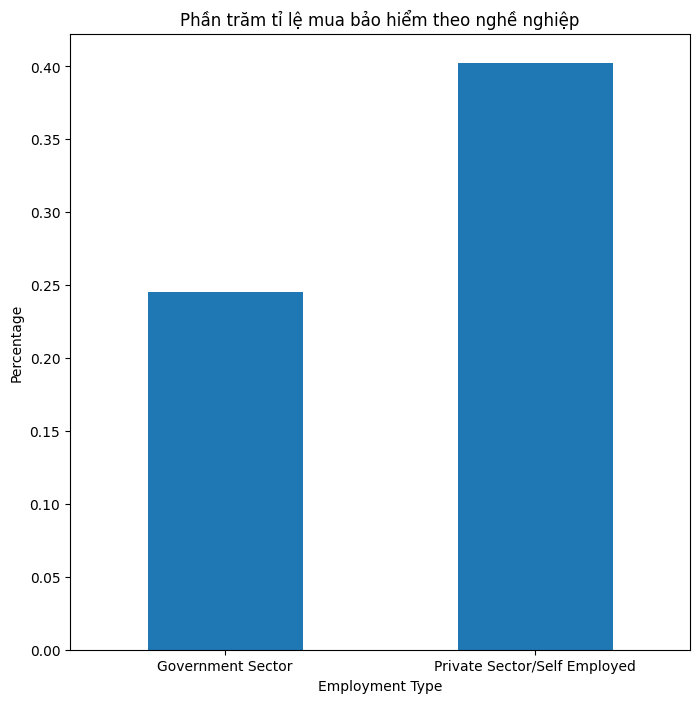

In [246]:
fig, ax = plt.subplots(figsize=(8,8))
(df.groupby('Employment Type').sum()['TravelInsurance']/df.groupby('Employment Type').count()['TravelInsurance']).plot(kind='bar')
plt.title('Phần trăm tỉ lệ mua bảo hiểm theo nghề nghiệp')
plt.ylabel('Percentage')
plt.xticks(rotation=360)
plt.show()


Ta thấy các khách hàng là kinh doanh cá nhân hay làm việc tự do thường có xu hướng mua bảo hiểm nhiều hơn là các khách hàng làm việc trong chính phủ. Điều này cũng hợp lý bởi vì nhân viên chính phủ thường được hưởng nhiều phúc lợi hơn.

### Graduate or Not

<ipython-input-247-771a05b4e334>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  (df.groupby('GraduateOrNot').sum()['TravelInsurance']/df.groupby('GraduateOrNot').count()['TravelInsurance']).plot(kind='bar')


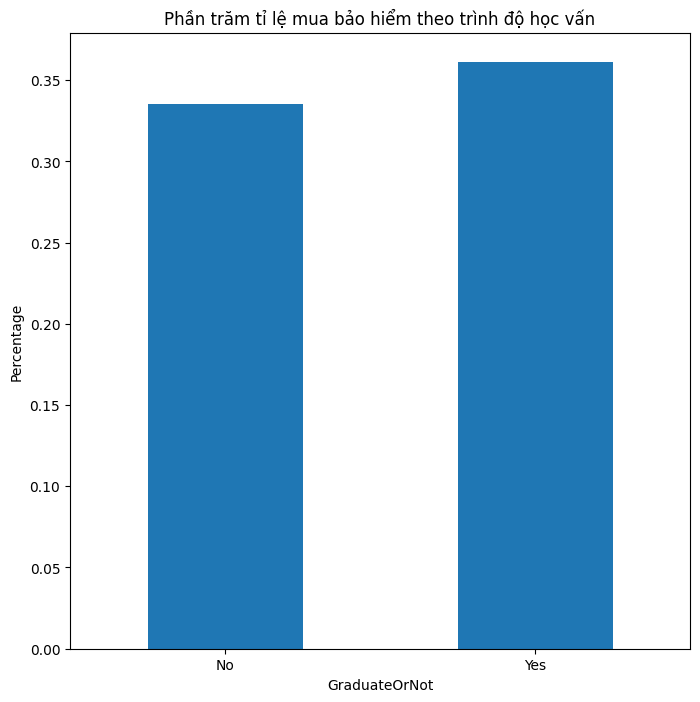

In [247]:
fig, ax = plt.subplots(figsize=(8,8))
(df.groupby('GraduateOrNot').sum()['TravelInsurance']/df.groupby('GraduateOrNot').count()['TravelInsurance']).plot(kind='bar')
plt.title('Phần trăm tỉ lệ mua bảo hiểm theo trình độ học vấn')
plt.ylabel('Percentage')
plt.xticks(rotation=360)
plt.show()

Có vẻ như mua hay không mua bảo hiểm không có sự khác biệt quá lớn đối với những khách hàng đã tốt nghiệp hay chưa tốt nghiệp

### AnnualIncome

<ipython-input-248-9bdcf3b9499b>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  (df.groupby('AnnualIncome').sum()['TravelInsurance']/df.groupby('AnnualIncome').count()['TravelInsurance']).plot(kind='bar')


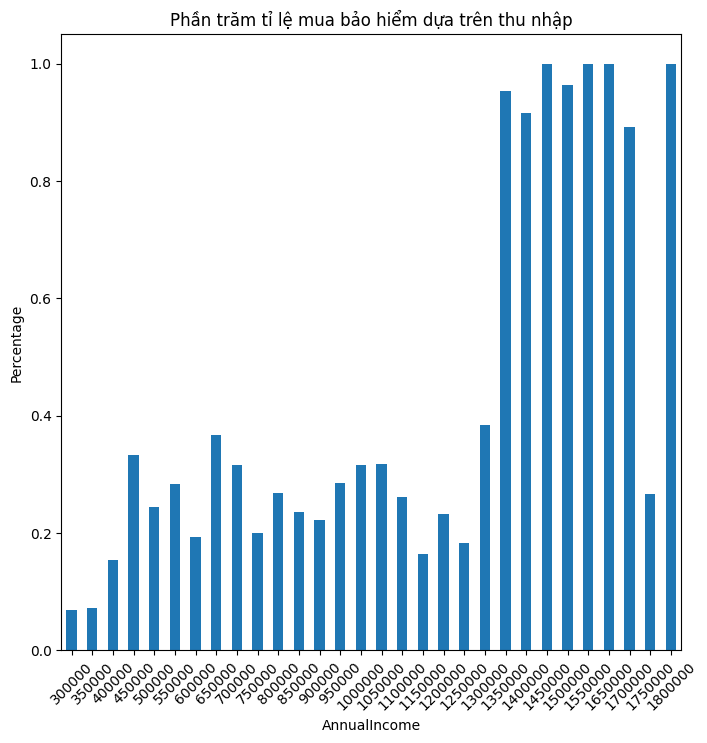

In [248]:
fig, ax = plt.subplots(figsize=(8,8))
(df.groupby('AnnualIncome').sum()['TravelInsurance']/df.groupby('AnnualIncome').count()['TravelInsurance']).plot(kind='bar')
plt.title('Phần trăm tỉ lệ mua bảo hiểm dựa trên thu nhập')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.show()

Những khách hàng có thu nhập càng cao thì có khả năng sẽ mua bảo hiểm cao hơn những khách hàng còn lại.

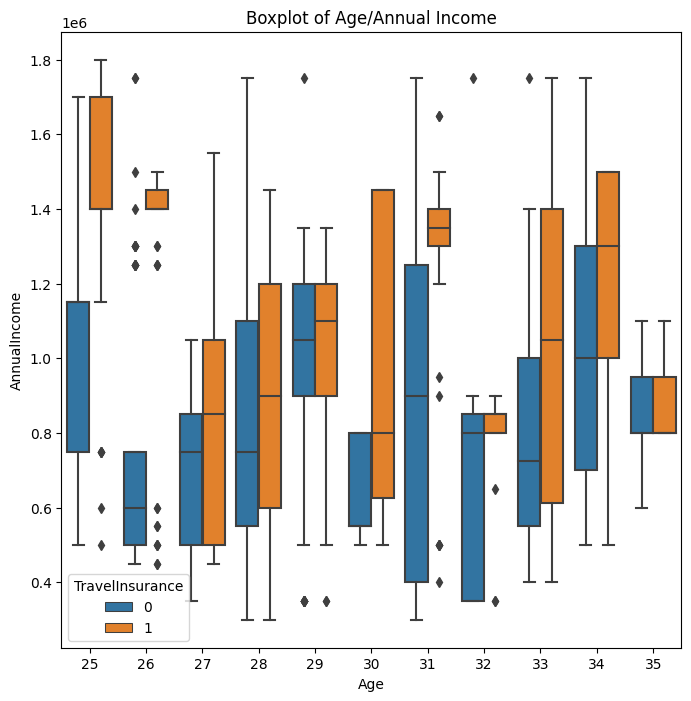

In [249]:
fig,ax=plt.subplots(figsize=(8,8))
sns.boxplot(x='Age',y='AnnualIncome',hue='TravelInsurance',data=df)
plt.title('Boxplot of Age/Annual Income')
plt.show()

Có vẻ trong từng nhóm tuổi, những người có thu nhập cao thường sẽ có xu hướng mua bảo hiểm nhiều hơn là những người có thu nhập thấp hơn.

### TravelInsurance

<Axes: xlabel='TravelInsurance', ylabel='count'>

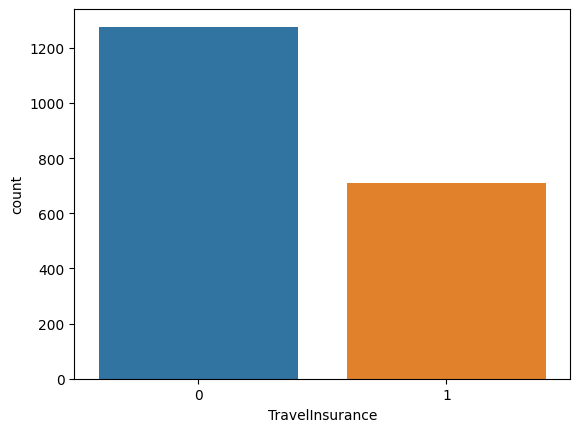

In [250]:
sns.countplot(x='TravelInsurance', data=df)

Ta thấy bộ dữ liệu có hiện tượng bị imbalance khi số bản ghi ở lớp 0 nhiều hơn rất nhiều so với lớp 1. Điều này có lẽ sẽ làm giảm chất lượng của mô hình trên label 1, cũng là label mà ta quan tâm trong bài toán này.

## Preprocessing

Trong phần này, ta sẽ xóa cột `Unnamed: 0` ra khỏi bộ dữ liệu.

In [251]:
def preprocessing_data(df):
    """
    Preprocess your data (eg. Drop null datapoints or fill missing data)
    :param df: pandas DataFrame
    :return: pandas DataFrame
    """
    preprocessed_df = df.copy()
    preprocessed_df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
    return preprocessed_df

In [252]:
preprocessed_df = preprocessing_data(df)
preprocessed_df.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


## Feature Engineering

Sử dụng LabelEncoder để chuyển các cột categorical sang dạng numerical.

<Axes: >

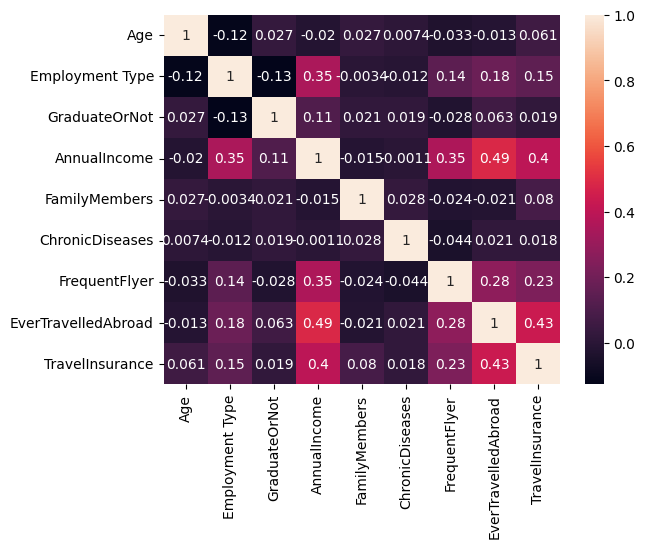

In [253]:
def apply_feature_engineering(df):
    """
    Apply all feature engineering to transform your data into number
    :param df: pandas DataFrame
    :return: pandas DataFrame
    """
    engineered_df = df.copy()
    le = LabelEncoder()
    to_encode = ['Employment Type','GraduateOrNot','FrequentFlyer', 'EverTravelledAbroad']
    for index in to_encode:
      engineered_df[index] = le.fit_transform(engineered_df[index])

    return engineered_df

engineered_df = apply_feature_engineering(preprocessed_df)
sns.heatmap(engineered_df.corr(), annot=True)

In [254]:
engineered_df.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,0,1,400000,6,1,0,0,0
1,31,1,1,1250000,7,0,0,0,0
2,34,1,1,500000,4,1,0,0,1
3,28,1,1,700000,3,1,0,0,0
4,28,1,1,700000,8,1,1,0,0


Tách bộ dữu liệu ra thành X tương ứng với dữ liệu đầu vào của mô hình và y là target của bài toán.

In [255]:
def prepare_X_y(df):
    """
    Feature engineering and create X and y
    :param df: pandas dataframe
    :return: (X, y) output feature matrix (dataframe), target (series)
    """
    feature_names = df.columns.tolist()
    feature_names.remove("TravelInsurance")

    X = df[feature_names].values
    y = df.TravelInsurance.values
    return X, y

X, y = prepare_X_y(engineered_df)

## Apply machine learning model

## Train-test split

In [256]:
RANDOM_STATE = 188
TRAIN_SIZE = 0.7

trainX, testX ,trainY, testY = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

## Các Model Naive Bayes

In [257]:
gauNB_model = GaussianNB()
gauNB_model.fit(trainX, trainY)

multiNB_model =  MultinomialNB()
multiNB_model.fit(trainX, trainY)

compNB_model =  ComplementNB()
compNB_model.fit(trainX, trainY)

berNB_model =  BernoulliNB()
berNB_model.fit(trainX, trainY)

cateNB_model =  CategoricalNB()
cateNB_model.fit(trainX, trainY)

CategoricalNB()

In [258]:
model_lst = [gauNB_model, multiNB_model, compNB_model, berNB_model, cateNB_model]

for model in model_lst:
    model_name = model.__class__.__name__
    predict = model.predict(testX)
    print("*" * 30)
    print(f'{model_name}:')
    print(classification_report(testY, predict))
    print(accuracy_score(testY, predict))
    print('*' * 30)

******************************
GaussianNB:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       403
           1       0.70      0.57      0.63       194

    accuracy                           0.78       597
   macro avg       0.75      0.73      0.74       597
weighted avg       0.77      0.78      0.77       597

0.7805695142378559
******************************
******************************
MultinomialNB:
              precision    recall  f1-score   support

           0       0.80      0.69      0.74       403
           1       0.50      0.64      0.56       194

    accuracy                           0.68       597
   macro avg       0.65      0.67      0.65       597
weighted avg       0.70      0.68      0.68       597

0.6767169179229481
******************************
******************************
ComplementNB:
              precision    recall  f1-score   support

           0       0.80      0.67      0.73       403
   

## Feature Scalling

In [259]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(trainX)
X_test_scaled = scaler.transform(testX)

In [260]:
gauNB_model = GaussianNB()
gauNB_model.fit(X_train_scaled, trainY)

multiNB_model =  MultinomialNB()
multiNB_model.fit(X_train_scaled, trainY)

compNB_model =  ComplementNB()
compNB_model.fit(X_train_scaled, trainY)

berNB_model =  BernoulliNB()
berNB_model.fit(X_train_scaled, trainY)

cateNB_model =  CategoricalNB()
cateNB_model.fit(X_train_scaled, trainY)

CategoricalNB()

In [261]:
model_lst = [gauNB_model, multiNB_model, compNB_model, berNB_model, cateNB_model]

for model in model_lst:
    model_name = model.__class__.__name__
    predict = model.predict(X_test_scaled)
    print("*" * 30)
    print(f'{model_name} with MinMaxScaler: ')
    print(classification_report(testY, predict))
    print(accuracy_score(testY, predict))
    print('*' * 30)

******************************
GaussianNB with MinMaxScaler: 
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       403
           1       0.71      0.60      0.65       194

    accuracy                           0.79       597
   macro avg       0.76      0.74      0.75       597
weighted avg       0.78      0.79      0.78       597

0.7889447236180904
******************************
******************************
MultinomialNB with MinMaxScaler: 
              precision    recall  f1-score   support

           0       0.79      0.95      0.86       403
           1       0.81      0.48      0.61       194

    accuracy                           0.80       597
   macro avg       0.80      0.71      0.73       597
weighted avg       0.80      0.80      0.78       597

0.7956448911222781
******************************
******************************
ComplementNB with MinMaxScaler: 
              precision    recall  f1-score   support



## Phương pháp PCA

Đối với phương pháp PCA thì ta chỉ có thể sử dụng được với ba model là GaussianNB, BernoulliNB và CategoricalNB vì sau khi áp dụng PCA sẽ tạo ra các giá trị âm - không thể làm input vủa các model còn lại.

In [262]:
pca = PCA()
X_train_scaled_pca = pca.fit_transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

In [263]:
gauNB_model = GaussianNB()
gauNB_model.fit(X_train_scaled_pca, trainY)

berNB_model =  BernoulliNB()
berNB_model.fit(X_train_scaled_pca, trainY)

cateNB_model =  CategoricalNB()
cateNB_model.fit(X_train_scaled_pca, trainY)

CategoricalNB()

In [264]:
model_lst = [gauNB_model, berNB_model, cateNB_model]

for model in model_lst:
    model_name = model.__class__.__name__
    predict = model.predict(X_test_scaled_pca)
    print("*" * 30)
    print(f'{model_name} with PCA:')
    print(classification_report(testY, predict))
    print(accuracy_score(testY, predict))
    print('*' * 30)

******************************
GaussianNB with PCA:
              precision    recall  f1-score   support

           0       0.82      0.92      0.87       403
           1       0.77      0.58      0.66       194

    accuracy                           0.81       597
   macro avg       0.79      0.75      0.76       597
weighted avg       0.80      0.81      0.80       597

0.8073701842546064
******************************
******************************
BernoulliNB with PCA:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       403
           1       0.74      0.60      0.66       194

    accuracy                           0.80       597
   macro avg       0.78      0.75      0.76       597
weighted avg       0.80      0.80      0.79       597

0.8006700167504187
******************************
******************************
CategoricalNB with PCA:
              precision    recall  f1-score   support

           0       0.72      0.

## Chọn ra Model Naive Bayes phù hợp nhất.

Tập dữ liệu với 1277 bản ghi label 0 và 710 bản ghi label 1 có sự mất cân bằng đáng kể giữa hai lớp và được xem là một trường hợp imbalance trong bài toán phân loại. Tỷ lệ giữa các lớp chênh lệch khác lớn khi lớp 1 chỉ chiếm khoảng 36% tổng số dữ liệu.\
Khi một trong hai lớp chiếm phần lớn số lượng dữ liệu, mô hình huấn luyện có thể có xu hướng dự đoán theo lớp đa số, dẫn đến kết quả phân loại không chính xác cho lớp thiểu số. Điều đó cũng được thể hiện khi mà các model ta đã xây dựng ở phía trên đa phần đều thể hiện rất tệ trên label 1 (Mua bảo hiểm) nhưng lại khá tốt trên label 0 (Không mua bảo hiểm).

Khi hiện tượng mất cân bằng dữ liệu nghiêm trọng xảy ra thì việc sử dụng độ accuracy làm thước đo đánh giá mô hình thường không hiệu quả bởi hầu hết chúng đều đạt độ chính xác rất cao. Một mô hình ngẫu nhiên dự báo toàn bộ là nhãn thuộc nhóm đa số cũng sẽ mang lại kết quả gần bằng 100%. Khi đó ta có thể cân nhắc tới một số metrics thay thế như precision, recall, f1-score,.... Các chỉ số này sẽ không quá lớn để dẫn tới ngộ nhận độ chính xác, đồng thời chúng tập trung hơn vào việc đánh giá độ chính xác trên nhóm thiểu số, nhóm mà chúng ta muốn dự báo chính xác hơn so với nhóm đa số.

Vì đây là bài toán dự đoán hành vi mua bảo hiểm của một khách hàng, cho nên xây dựng mô hình ta cần chú ý vào 2 tiêu chí:

- Recall: Việc bao phủ được hết các khách hàng có thể muốn mua bảo hiểm là mục tiêu cốt lõi của chiến lược tiếp thị, giúp sản phẩm hoặc dịch vụ đến được với nhiều khách hàng tiềm năng nhất có thể. 

- Precision: Tuy nhiên, việc dự đoán chính xác được khách hàng nào mua hàng cũng là rất quan trọng. Nếu một công ty có thể tăng xác suất dự đoán được những khách hàng cụ thể nào sẽ mua sản phẩm của họ, họ có thể tập trung vào những nỗ lực tiếp thị đến các khách hàng đó để tối đa hóa khả năng bán hàng, giúp giảm thiểu chi phí, tiết kiệm thời gian và nguồn nhân lực.

Vì vậy, để đánh giá các model được xây dựng, ở đây ta sẽ kết hợp cả hai mục tiêu, tập trung vào việc bao phủ được nhiều khách hàng tiềm năng nhất có thể, đồng thời cải thiện khả năng dự đoán chính xác khách hàng mua hàng để tối đa hóa lợi nhuận cũng như thời gian. Lúc này, ta sẽ xem xét đánh giá model qua F1-score.

Với các model đã xây dựng ở trên, ta sẽ chú ý vào label 1, là lớp các khách hàng mua bảo hiểm, thì ta thấy có 2 model là thu được kết quả giữa Precission và Recall không có sự chêch lệch quá không lớn, đồng thời F1-score cũng tạm chấp nhận so với các model còn lại. Đó là:
- GaussianNB với dữ liệu sau khi đã được scale, cho ra kết quả trên label 1 là Precissin: 0.71, Recall: 0.60, F1-score: 0.65 và Accuracy là 0.79
- ComplementNB với dữ liệu sau khi scale, cho ra kết quả trên label 1 là Precissin: 0.65, Recall: 0.60, F1-score: 0.62 và Accuracy là 0.77.

Trong tài liệu về Naive Bayes của Scikit-learn thì có nhắc đến việc model ComplementNB sẽ phù hớp với các tập dữ liệu bị imbalance, nhưng theo đánh giá thì nó cũng chưa thể hiện được nhiều.

### Grid-Search

Để đánh giá một cách công bằng nhất, ta sẽ tiến hành Grid search với tất cả 5 model, với metric được chọn sẽ tối ưu là `F1-score`. \
Vì ComplementNB và MultinomialNB là 2 thuật toán không thể sử dụng cùng lúc với PCA (khi dùng PCA thì các input sẽ xuất hiện các số âm, mà các model này không nhận đầu vào là 1 số âm) nên đối với 2 thuật toán này, ta chỉ áp dụng kỹ thuật scaler.

#### GridSearch với GaussianNB

In [265]:
pca = PCA()
gau_nb = GaussianNB()
scaler = MinMaxScaler()
pipe = Pipeline(steps=[("scaler", scaler),("pca", pca), ("gau_nb", gau_nb)])

var_smoothing_values = np.linspace(0, 1, 100)
'''scoring = {'F1_score': make_scorer(f1_score, pos_label=1)}'''

param_grid = {
    "scaler__feature_range": [(-1, 1), (0, 1)],
    "pca__n_components": [1, 2, 3, 4, 5, 6, 7, 8, None],
    'gau_nb__var_smoothing': var_smoothing_values
    }

search = GridSearchCV(pipe, param_grid, scoring='f1', n_jobs=2)
search.fit(trainX, trainY)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)
predicted_label = search.predict(testX)
print(classification_report(testY, predicted_label))

Best parameter (CV score=0.596):
{'gau_nb__var_smoothing': 0.010101010101010102, 'pca__n_components': 8, 'scaler__feature_range': (-1, 1)}
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       403
           1       0.80      0.58      0.67       194

    accuracy                           0.82       597
   macro avg       0.81      0.75      0.77       597
weighted avg       0.81      0.82      0.81       597



#### GridSearch với BernoulliNB.

In [266]:
pca = PCA()
ber_nb = BernoulliNB()
scaler = MinMaxScaler()
pipe = Pipeline(steps=[("scaler", scaler),("pca", pca), ("ber_nb", ber_nb)])


alpha_values = np.linspace(0, 1, 100)
param_grid = {
    "scaler__feature_range": [(-1, 1), (0, 1)],
    "pca__n_components": [1, 2, 3, 4, 5, 6, 7, 8, None],
    'ber_nb__alpha': alpha_values
    }

search = GridSearchCV(pipe, param_grid, scoring="f1", n_jobs=2)
search.fit(trainX, trainY)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
predicted_label = search.predict(testX)
print(classification_report(testY, predicted_label))

Best parameter (CV score=0.540):
{'ber_nb__alpha': 0.0, 'pca__n_components': 7, 'scaler__feature_range': (-1, 1)}
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       403
           1       0.64      0.56      0.59       194

    accuracy                           0.75       597
   macro avg       0.72      0.70      0.71       597
weighted avg       0.75      0.75      0.75       597



/usr/local/lib/python3.9/dist-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(


#### GridSearch với CategoricalNB

In [267]:
pca = PCA()
cate_nb = CategoricalNB()
scaler = MinMaxScaler()
pipe = Pipeline(steps=[("scaler", scaler),("pca", pca), ("cate_nb", cate_nb)])


alpha_values = np.linspace(0, 1, 100)
param_grid = {
    "scaler__feature_range": [(-1, 1), (0, 1)],
    "pca__n_components": [1, 2, 3, 4, 5, 6, 7, 8, None],
    'cate_nb__alpha': alpha_values
    }

search = GridSearchCV(pipe, param_grid, scoring="f1", n_jobs=2)
search.fit(trainX, trainY)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
predicted_label = search.predict(testX)
print(classification_report(testY, predicted_label))

Best parameter (CV score=0.260):
{'cate_nb__alpha': 0.0, 'pca__n_components': 5, 'scaler__feature_range': (0, 1)}
              precision    recall  f1-score   support

           0       0.72      0.99      0.84       403
           1       0.93      0.20      0.33       194

    accuracy                           0.74       597
   macro avg       0.82      0.60      0.58       597
weighted avg       0.79      0.74      0.67       597



/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
4500 fits failed out of a total of 9000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4500 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/naive_bayes.py", line 1395, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "/usr/loca

#### GridSearch với ComplementNB.

In [268]:
comp_nb = ComplementNB()
scaler = MinMaxScaler()
pipe = Pipeline(steps=[("scaler", scaler), ("comp_nb", comp_nb)])

alpha_values = np.linspace(0, 1, 100)
param_grid = {
    "scaler__feature_range": [(-1, 1), (0, 1)],
    'comp_nb__alpha': alpha_values
    }

search = GridSearchCV(pipe, param_grid, scoring="f1", n_jobs=2)
search.fit(trainX, trainY)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
predicted_label = search.predict(testX)
print(classification_report(testY, predicted_label))

Best parameter (CV score=0.562):
{'comp_nb__alpha': 0.0, 'scaler__feature_range': (0, 1)}
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       403
           1       0.65      0.60      0.62       194

    accuracy                           0.77       597
   macro avg       0.73      0.72      0.73       597
weighted avg       0.76      0.77      0.76       597



/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
500 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
500 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/naive_bayes.py", line 776, in fit
    self._count(X, Y)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/n

#### GridSearch với MultinomialNB.

In [269]:
multi_nb = MultinomialNB()
scaler = MinMaxScaler()
pipe = Pipeline(steps=[("scaler", scaler), ("multi_nb", multi_nb)])
alpha_values = np.linspace(0, 1, 100)
param_grid = {
    "scaler__feature_range": [(-1, 1), (0, 1)],
    'multi_nb__alpha': alpha_values
    }

search = GridSearchCV(pipe, param_grid, scoring="f1", n_jobs=2)
search.fit(trainX, trainY)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
predicted_label = search.predict(testX)
print(classification_report(testY, predicted_label))

Best parameter (CV score=0.536):
{'multi_nb__alpha': 0.0, 'scaler__feature_range': (0, 1)}
              precision    recall  f1-score   support

           0       0.79      0.95      0.86       403
           1       0.81      0.48      0.61       194

    accuracy                           0.80       597
   macro avg       0.80      0.71      0.73       597
weighted avg       0.80      0.80      0.78       597



/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
500 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
500 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/naive_bayes.py", line 776, in fit
    self._count(X, Y)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/n

#### Thử phương pháp Under Sampling để xử lý imbalance data.

Như đã phân tích trước đó, đây là 1 tập dữ liệu có hiện tượng imbalance và việc dự đoán trên label thật sự không được tốt, vì vậy ta sẽ thử dùng phương pháp Under Sampling để xử lý lại data bằng cách giảm số mẫu của lớp chiếm đa số.

In [270]:
from imblearn.under_sampling import AllKNN
allknn = AllKNN(n_neighbors=3)

X_train_res, y_train_res = allknn.fit_resample(trainX, trainY)

In [271]:
pca = PCA()
gau_nb = GaussianNB()
scaler = MinMaxScaler()
pipe = Pipeline(steps=[("scaler", scaler),("pca", pca), ("gau_nb", gau_nb)])

var_smoothing_values = np.linspace(0, 1, 100)
'''scoring = {'F1_score': make_scorer(f1_score, pos_label=1)}'''

param_grid = {
    "scaler__feature_range": [(-1, 1), (0, 1)],
    "pca__n_components": [1, 2, 3, 4, 5, 6, 7, 8, None],
    'gau_nb__var_smoothing': var_smoothing_values
    }

search = GridSearchCV(pipe, param_grid, scoring='f1', n_jobs=2)
search.fit(X_train_res, y_train_res)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)
predicted_label = search.predict(testX)
print(classification_report(testY, predicted_label))

Best parameter (CV score=0.698):
{'gau_nb__var_smoothing': 0.0, 'pca__n_components': 7, 'scaler__feature_range': (-1, 1)}
              precision    recall  f1-score   support

           0       0.85      0.82      0.84       403
           1       0.66      0.70      0.68       194

    accuracy                           0.78       597
   macro avg       0.75      0.76      0.76       597
weighted avg       0.79      0.78      0.79       597



Nhận xét: Khi dùng kỹ thuật under sampling để xử imbalance cho tập data thì độ đo Recall và F1-score trên label 1 đã được cải thiện nhưng độ chính xác khi dự đoán lại giảm xuống còn 0.66. Đồng thời Accuracy cũng giảm còn 0.78.

Tuy nhiên, theo như mục tiêu ban đầu là tối ưu hóa cả precision và recall cùng một lúc, thì ta sẽ chọn model có F1 score cao hơn, đó là model Gaussian cùng với data đã được xử lý imbalance (theo như thử nghiệm thì under sampling cùng với các model còn lại cũng chưa tìm ra kết quả cải thiện hơn). Kết quả của model này như sau:
- Presicion: 0.66
- Recall: 0.70
- F1 score: 0.68
- Accuracy: 0.78

Đây chính là model có F1-score cao nhất từ đầu đến giờ, các tham số được tối ưu bằng GridSearchCV như sau: `{'gau_nb__var_smoothing': 0.0, 'pca__n_components': 7, 'scaler__feature_range': (-1, 1)}`

Ta quyết định sẽ chọn Model này làm Model cuối cùng để xử lý bài toán này.

## Final - Include my best params

In [272]:
def build_model(X, y):
    """
    Design your model and train it (including your best params)
    :param X: feature matrix
    :param y: target
    :return: a model
    """
    gau_nb = GaussianNB()
    scaler = MinMaxScaler()
    pca = PCA()
    pipe = Pipeline(steps=[("scaler", scaler),("pca", pca), ("gau_nb", gau_nb)])

    var_smoothing_values = np.linspace(0, 1, 100)

    param_grid = {
        "scaler__feature_range": [(-1, 1), (0, 1)],
        "pca__n_components": [1, 2, 3, 4, 5, 6, 7, 8, None],
        'gau_nb__var_smoothing': var_smoothing_values
        }
    
    search = GridSearchCV(pipe, param_grid, scoring= 'f1', n_jobs=2)
    search.fit(X, y)
    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)
    return search

def calculate_performance(y_true, y_pred):
    """
    :param y_true: ground truth values
    :param y_pred: predictions
    :return:
    """
    print("precision", precision_score(y_true , y_pred))
    print("recall",recall_score(y_true , y_pred) )
    print("accuracy", accuracy_score(y_true, y_pred))
    print("F1", f1_score(y_true , y_pred))

    main_score = f1_score(y_true , y_pred)
    return main_score

model = build_model(X_train_res, y_train_res)

# Compare on training dataset
train_pred = model.predict(trainX)
print("Training performance:", calculate_performance(trainY, train_pred))
print()
# Compare on testing dataset
test_pred = model.predict(testX)
print("Testing performance:", calculate_performance(testY, test_pred))
print(classification_report(testY, test_pred))

Best parameter (CV score=0.698):
{'gau_nb__var_smoothing': 0.0, 'pca__n_components': 7, 'scaler__feature_range': (-1, 1)}
precision 0.6604938271604939
recall 0.622093023255814
accuracy 0.7410071942446043
F1 0.6407185628742516
Training performance: 0.6407185628742516

precision 0.6570048309178744
recall 0.7010309278350515
accuracy 0.7839195979899497
F1 0.6783042394014963
Testing performance: 0.6783042394014963
              precision    recall  f1-score   support

           0       0.85      0.82      0.84       403
           1       0.66      0.70      0.68       194

    accuracy                           0.78       597
   macro avg       0.75      0.76      0.76       597
weighted avg       0.79      0.78      0.79       597



In [273]:
def get_conclusion():
    return "7.1. Để đánh giá model trong bài toán này, em đã sử dụng F1-score. Bởi vì em muốn tối ưu cả" \
           "Precision và Recall. Thông thường các bài toán về Marketing thì người ta sẽ luôn mong muốn" \
           "phủ được nhiều khách hàng tìm năng càng tốt, góp phần tăng doanh thu. Nhưng việc xác suất dự đoán đúng"\
           "một người nào đó thật sự có nhu cầu mua hàng cũng rất cần thiết. Bằng việc hạn chế được sai sót khi dự đoán"\
           "ta cũng có thể tiết kiệm được ngân sách cũng như nhân lực, không làm phiền đến khách hàng, làm ảnh hưởng đến thương hiệu"\
           "của công ty."\
           "7.2. Bằng việc sử dụng GridSearchCV, ta cũng tìm ra các tham số tối ưu nhất cho model là: "\
           "'gau_nb__var_smoothing': 0.0, 'pca__n_components': 7, 'scaler__feature_range': (-1, 1)"\
           "Cũng như tham số n_neighbors=3 (tham số mặc định của AllKNN - Under Sampling)"

## Tài liệu tham khảo

Naive Bayes: https://scikit-learn.org/stable/modules/naive_bayes.html

Under Sampling - AllKNN: https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.AllKNN.html